In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from cvxopt import solvers, matrix

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3) #4设精度为3
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# solvers.options['show_progress'] = False  # 写求解器前，不显示运算过程

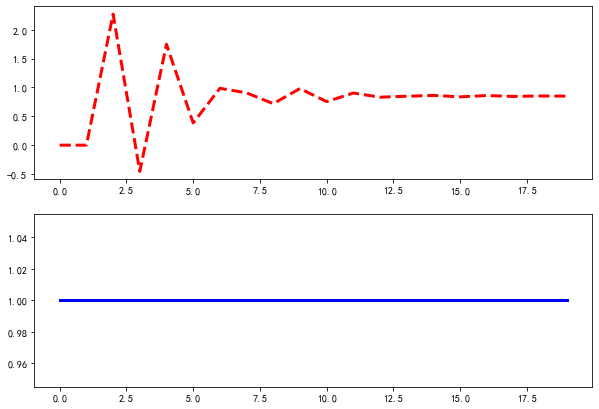

In [2]:
# plant

A_Poly = np.array([1.2, 0.47]).reshape(-1,1)
B_Poly = np.array([0.37, 1.9]).reshape(-1,1)
dt = 1  # 采样时间1s
t = np.arange(0,20,dt) # 构建时间序列
y_plant = np.zeros(len(t))
u_step = np.ones(len(t))
# u_step[len(B_Poly):] = 1

for k in range(len(A_Poly), len(t), dt):
    y_plant[k] = np.array([-1*y_plant[k-1], -1*y_plant[k-2],  u_step[k-1], u_step[k-2]]).reshape(-1,1).T @ np.r_[A_Poly, B_Poly]
# t_,y_,u_ = signal.lsim(plant,u_step,t)

plt.figure(1, figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(t,y_plant,'r--',linewidth=3)
plt.subplot(2,1,2)
plt.step(t,u_step,'b-',linewidth=3)
plt.show()

Text(0, 0.5, 'Response')

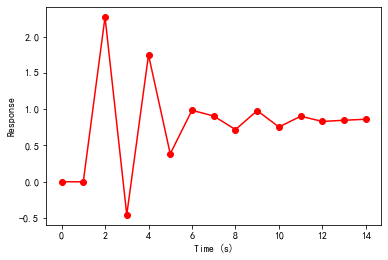

In [3]:
N = 15
# Step Response Model
a = y_plant[:N].reshape(-1, 1)
plt.plot(a, '-or')
plt.xlabel("Time (s)")
plt.ylabel("Response")

In [4]:
M = 10
P = 12
# A矩阵
A = np.tile(a.reshape(1,-1), (M,1)).T
row_indices = np.atleast_2d(np.arange(P)).T - np.arange(M)
col_indices = np.arange(M)
A = np.tril(A[row_indices,col_indices])
print(A)

Q = np.ones(P)
Q[np.where((a.reshape(1,-1))[0][:P]<=0)] = 0
Q = np.diag(Q)
R = np.identity(M) * 2.0 # 加入抑制
c = np.ones(M).reshape(-1,1)
c[1:]=0
d = (c.T @ np.linalg.inv(A.T @ Q @ A + R) @ A.T @ Q).T  # 用于求得的最优结果

# B矩阵
B = np.tril(np.ones((M, M)))

# h 等值修正
alpha = 0.8
h = np.ones((N,1)) 
h[1:,:] = alpha

# 位移矩阵
S = np.r_[np.c_[np.zeros((N-1)), np.identity(N-1)], np.zeros(N).reshape(1,-1)]
S[-1, -1] = 1


[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.27   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.454  2.27   0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.748 -0.454  2.27   0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.386  1.748 -0.454  2.27   0.     0.     0.     0.     0.     0.   ]
 [ 0.985  0.386  1.748 -0.454  2.27   0.     0.     0.     0.     0.   ]
 [ 0.906  0.985  0.386  1.748 -0.454  2.27   0.     0.     0.     0.   ]
 [ 0.719  0.906  0.985  0.386  1.748 -0.454  2.27   0.     0.     0.   ]
 [ 0.981  0.719  0.906  0.985  0.386  1.748 -0.454  2.27   0.     0.   ]
 [ 0.755  0.981  0.719  0.906  0.985  0.386  1.748 -0.454  2.27   0.   ]
 [ 0.903  0.755  0.981  0.719  0.906  0.985  0.386  1.748 -0.454  2.27 ]]


In [57]:
P = matrix(np.diag([1.0,0]))  #  对于一些特殊矩阵，用numpy创建会方便很多（在本例中可能感受不大）
q = matrix(np.array([3.0,4]).T)
G = matrix(np.array([[-1.0,0],[0,-1],[-1,-3],[2,5],[3,4]]))
h = matrix(np.array([0.0,0,-15,100,80]).T)
print(np.array(solvers.qp(P,q,G,h)['x']))

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  0e+00  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  1e-16  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  6e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  8e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  6e-17  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  3e-16  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  6e-17  7e-17
 7:  2.0001e+01  2.0000e+01  9e-04  2e-16  9e-17
 8:  2.0000e+01  2.0000e+01  9e-06  2e-16  2e-16
Optimal solution found.
[[0.]
 [5.]]


In [46]:
print(sol['x']) 
print(sol['primal objective'])

[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [5]:
# 仿真
Lsim = 200 # 仿真长度
wp = np.ones((Lsim, 1)) # SP向量
wp[:60,0] = 5.0
wp[60:110,0] = 10.0
wp[110:,0] = 6.0

# 约束
u_min, u_max = -10.0, 20.0
y_min, y_max = -0.5, 30.0

# 初始化
y = np.ones(Lsim)
y1_hat = np.ones((N,1))* y[k] # N维
u = np.ones(Lsim)

# 进入仿真循环
for i in range(len(A_Poly), Lsim - P, dt):
    # 检测实际输出并计算误差
    y[i] = np.array([-1*y[i-1], -1*y[i-2],  u[i-1], u[i-2]]).reshape(-1,1).T @ np.r_[A_Poly, B_Poly]
    e = y[i] - y1_hat[0]

    # 预测值矫正
    y_cor = y1_hat + h * e
    y0_hat = S @ y_cor # N维
    yp0_hat = y0_hat[0: P,:] # P维

    # QP计算控制增量
    QP_P = matrix(2*(A.T @ Q @ A + R))  # H
    QP_G = matrix(np.r_[-B, B, -A, A]) 
    # l
    QP_h = matrix(np.r_[-np.ones((M, 1)) * (u_min - u[i-1]), 
                        np.ones((M, 1)) * (u_max - u[i-1]), 
                        (yp0_hat - np.ones((P, 1)) * y_min), 
                        (np.ones((P, 1)) * y_max - yp0_hat)])
    # c
    QP_q =matrix(-2*((wp[i: i + P,:] - yp0_hat).T @ Q @ A).T)
    delta_u = np.array(solvers.qp(QP_P,QP_q,QP_G,QP_h)['x'])[0]
    # 计算控制量
    u[i] = u[i-1] + delta_u

    # 计算输出预测值
    y1_hat = y0_hat + a * delta_u # + 可观测扰动 b * delta_v 


     pcost       dcost       gap    pres   dres
 0: -5.5701e+01 -8.0740e+03  8e+03  5e-17  9e-16
 1: -1.2126e+02 -6.8034e+02  6e+02  2e-16  4e-16
 2: -1.5641e+02 -1.8304e+02  3e+01  2e-16  2e-16
 3: -1.5717e+02 -1.5775e+02  6e-01  2e-16  1e-16
 4: -1.5717e+02 -1.5718e+02  7e-03  2e-16  1e-16
 5: -1.5717e+02 -1.5717e+02  7e-05  2e-16  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.6877e+01 -7.8458e+03  8e+03  7e-17  7e-16
 1: -2.1583e+01 -5.5253e+02  5e+02  2e-16  7e-16
 2: -5.3230e+01 -7.7215e+01  2e+01  2e-16  3e-16
 3: -5.3514e+01 -5.3800e+01  3e-01  2e-16  1e-16
 4: -5.3514e+01 -5.3517e+01  3e-03  2e-16  1e-16
 5: -5.3514e+01 -5.3514e+01  3e-05  1e-16  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2478e+02 -5.3419e+03  5e+03  7e-17  1e-15
 1:  1.8055e+01 -3.9848e+02  4e+02  2e-16  1e-15
 2: -9.7349e+00 -2.6677e+01  2e+01  1e-16  3e-16
 3: -9.8668e+00 -1.0045e+01  2e-01  2e-16  1e-16
 4: -9.8668e+00 -9.8686e

     pcost       dcost       gap    pres   dres
 0:  3.8485e+01 -6.7083e+03  7e+03  4e-17  8e-16
 1: -2.2803e+00 -4.3426e+02  4e+02  2e-16  8e-16
 2: -2.1155e+01 -3.7717e+01  2e+01  2e-16  2e-16
 3: -2.1304e+01 -2.1496e+01  2e-01  2e-16  2e-16
 4: -2.1304e+01 -2.1306e+01  2e-03  2e-16  2e-16
 5: -2.1304e+01 -2.1304e+01  2e-05  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.8392e+01 -4.9940e+03  5e+03  8e-17  1e-15
 1:  8.6226e+00 -3.4906e+02  4e+02  2e-16  1e-15
 2: -1.0573e+01 -2.3166e+01  1e+01  2e-16  3e-16
 3: -1.0643e+01 -1.0772e+01  1e-01  2e-16  1e-16
 4: -1.0643e+01 -1.0644e+01  1e-03  2e-16  9e-17
 5: -1.0643e+01 -1.0643e+01  1e-05  2e-16  1e-16
 6: -1.0643e+01 -1.0643e+01  1e-07  1e-16  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.9999e+01 -5.9797e+03  6e+03  6e-17  2e-15
 1:  1.7930e+01 -3.9864e+02  4e+02  2e-16  1e-15
 2: -4.0364e+00 -1.9978e+01  2e+01  2e-16  6e-16
 3: -4.1562e+00 -4.3271e

 3: -1.4801e+02 -1.4804e+02  3e-02  2e-16  1e-16
 4: -1.4801e+02 -1.4801e+02  3e-04  2e-16  1e-16
 5: -1.4801e+02 -1.4801e+02  3e-06  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.7607e+00 -3.3291e+03  3e+03  5e-17  5e-16
 1: -1.0538e+01 -1.0778e+02  1e+02  2e-16  4e-16
 2: -1.0660e+01 -1.1658e+01  1e+00  2e-16  1e-16
 3: -1.0660e+01 -1.0670e+01  1e-02  2e-16  1e-16
 4: -1.0660e+01 -1.0661e+01  1e-04  2e-16  1e-16
 5: -1.0660e+01 -1.0660e+01  1e-06  2e-16  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.6795e-01 -4.2276e+03  4e+03  6e-17  1e-15
 1: -3.8960e+00 -1.0249e+02  1e+02  2e-16  1e-15
 2: -4.1407e+00 -5.2501e+00  1e+00  2e-16  2e-16
 3: -4.1407e+00 -4.1518e+00  1e-02  2e-16  2e-16
 4: -4.1407e+00 -4.1408e+00  1e-04  2e-16  2e-16
 5: -4.1407e+00 -4.1407e+00  1e-06  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.0775e+01 -5.1860e+03  5e+03  5e-17  4e-16


 5: -9.0185e+00 -9.0185e+00  1e-06  2e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.7117e+01 -3.9226e+03  4e+03  7e-17  6e-16
 1: -3.1725e+01 -2.0963e+02  2e+02  2e-16  4e-16
 2: -3.5573e+01 -4.0199e+01  5e+00  2e-16  1e-16
 3: -3.5579e+01 -3.5625e+01  5e-02  2e-16  7e-17
 4: -3.5579e+01 -3.5580e+01  5e-04  2e-16  1e-16
 5: -3.5579e+01 -3.5579e+01  5e-06  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.0524e+00 -3.8101e+03  4e+03  6e-17  3e-15
 1: -4.1213e+00 -1.7252e+02  2e+02  2e-16  1e-15
 2: -5.2671e+00 -7.4886e+00  2e+00  2e-16  2e-16
 3: -5.2676e+00 -5.2898e+00  2e-02  2e-16  1e-16
 4: -5.2676e+00 -5.2678e+00  2e-04  2e-16  2e-16
 5: -5.2676e+00 -5.2676e+00  2e-06  2e-16  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2521e+01 -3.4537e+03  3e+03  6e-17  1e-15
 1: -1.7064e+01 -1.3558e+02  1e+02  2e-16  7e-16
 2: -1.7588e+01 -1.8957e+01  1e+00  2e-16  1e-16


 5: -2.2246e+00 -2.2246e+00  8e-06  2e-16  2e-16
 6: -2.2246e+00 -2.2246e+00  8e-08  2e-16  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1737e+01 -5.6907e+03  6e+03  7e-17  2e-15
 1:  1.0435e+00 -3.1490e+02  3e+02  2e-16  1e-15
 2: -6.2027e+00 -1.4081e+01  8e+00  2e-16  1e-16
 3: -6.2212e+00 -6.3009e+00  8e-02  1e-16  6e-17
 4: -6.2212e+00 -6.2220e+00  8e-04  2e-16  2e-16
 5: -6.2212e+00 -6.2212e+00  8e-06  2e-16  1e-16
 6: -6.2212e+00 -6.2212e+00  8e-08  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.7276e+01 -3.9628e+03  4e+03  5e-17  9e-16
 1: -1.4344e+01 -2.6439e+02  3e+02  2e-16  3e-16
 2: -2.2539e+01 -2.8540e+01  6e+00  2e-16  1e-16
 3: -2.2550e+01 -2.2610e+01  6e-02  2e-16  8e-17
 4: -2.2550e+01 -2.2551e+01  6e-04  2e-16  7e-17
 5: -2.2550e+01 -2.2550e+01  6e-06  2e-16  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.8973e+01 -5.4754e+03  6e+03  7e-17  3e-15


 2: -7.6086e-01 -9.7972e+00  9e+00  2e-16  9e-16
 3: -7.8794e-01 -8.7961e-01  9e-02  1e-16  2e-16
 4: -7.8794e-01 -7.8886e-01  9e-04  2e-16  1e-16
 5: -7.8794e-01 -7.8795e-01  9e-06  2e-16  2e-16
 6: -7.8794e-01 -7.8794e-01  9e-08  2e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3362e+01 -5.8167e+03  6e+03  5e-17  1e-15
 1: -1.9547e+00 -3.3314e+02  3e+02  1e-16  9e-16
 2: -1.1029e+01 -1.9989e+01  9e+00  2e-16  2e-16
 3: -1.1057e+01 -1.1149e+01  9e-02  2e-16  1e-16
 4: -1.1057e+01 -1.1058e+01  9e-04  2e-16  1e-16
 5: -1.1057e+01 -1.1057e+01  9e-06  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.4717e+01 -4.6538e+03  5e+03  6e-17  2e-15
 1:  5.0595e+00 -2.8600e+02  3e+02  2e-16  9e-16
 2: -4.5720e+00 -1.1970e+01  7e+00  2e-16  4e-16
 3: -4.5884e+00 -4.6627e+00  7e-02  2e-16  5e-17
 4: -4.5884e+00 -4.5892e+00  7e-04  2e-16  1e-16
 5: -4.5884e+00 -4.5884e+00  7e-06  2e-16  7e-17
 6: -4.5884e+00 -4.5884

 2: -2.4215e+00 -9.9561e+00  8e+00  1e-16  5e-16
 3: -2.4387e+00 -2.5144e+00  8e-02  2e-16  7e-17
 4: -2.4387e+00 -2.4394e+00  8e-04  2e-16  1e-16
 5: -2.4387e+00 -2.4387e+00  8e-06  2e-16  9e-17
 6: -2.4387e+00 -2.4387e+00  8e-08  2e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.5336e+01 -5.1693e+03  5e+03  5e-17  1e-15
 1:  8.5419e+00 -3.0928e+02  3e+02  2e-16  1e-15
 2: -1.9273e+00 -1.0444e+01  9e+00  2e-16  4e-16
 3: -1.9505e+00 -2.0365e+00  9e-02  2e-16  2e-16
 4: -1.9505e+00 -1.9514e+00  9e-04  2e-16  1e-16
 5: -1.9505e+00 -1.9505e+00  9e-06  2e-16  7e-17
 6: -1.9505e+00 -1.9505e+00  9e-08  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.9748e+01 -5.5559e+03  6e+03  6e-17  2e-15
 1:  2.6332e+00 -3.1882e+02  3e+02  2e-16  7e-16
 2: -6.5934e+00 -1.5253e+01  9e+00  2e-16  4e-16
 3: -6.6205e+00 -6.7089e+00  9e-02  2e-16  2e-16
 4: -6.6205e+00 -6.6214e+00  9e-04  2e-16  1e-16
 5: -6.6205e+00 -6.6205

     pcost       dcost       gap    pres   dres
 0:  4.5256e+01 -5.1030e+03  5e+03  5e-17  2e-15
 1:  8.8818e+00 -3.0447e+02  3e+02  2e-16  2e-15
 2: -1.3763e+00 -9.7063e+00  8e+00  2e-16  9e-16
 3: -1.3986e+00 -1.4827e+00  8e-02  2e-16  1e-16
 4: -1.3987e+00 -1.3995e+00  8e-04  2e-16  1e-16
 5: -1.3987e+00 -1.3987e+00  8e-06  2e-16  1e-16
 6: -1.3987e+00 -1.3987e+00  8e-08  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.3823e+01 -5.4148e+03  5e+03  8e-17  3e-15
 1:  5.3505e+00 -3.1152e+02  3e+02  2e-16  2e-15
 2: -3.9641e+00 -1.2444e+01  8e+00  2e-16  4e-16
 3: -3.9895e+00 -4.0758e+00  9e-02  2e-16  9e-17
 4: -3.9895e+00 -3.9904e+00  9e-04  2e-16  7e-17
 5: -3.9895e+00 -3.9895e+00  9e-06  2e-16  1e-16
 6: -3.9895e+00 -3.9895e+00  9e-08  2e-16  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.4137e+01 -4.9832e+03  5e+03  6e-17  4e-15
 1:  9.2367e+00 -2.9526e+02  3e+02  2e-16  4e-15
 2: -3.6324e-01 -8.2410e

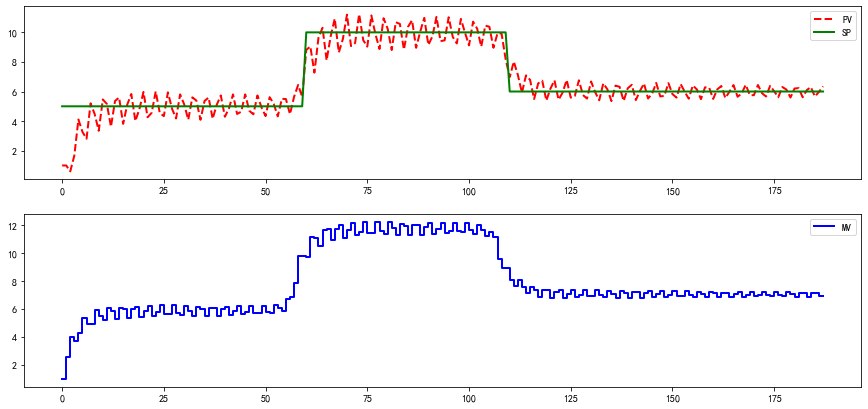

In [6]:
plt.figure(2, figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(y[:-P],'r--',linewidth=2)
plt.plot(wp[:-P],'g-',linewidth=2)
plt.legend(['PV','SP'])
plt.subplot(2,1,2)
plt.step(u[:-P],'b-',linewidth=2)
plt.legend(['MV'])
plt.show()